<p style="text-align: center; font-size: 28px;"><b>Random Forests</b></p>

# Introduction

Random forests aren’t just for classification—they also work well for **regression** when the target is continuous (e.g., a numeric `price`). The model builds many decision trees on **bootstrapped** samples of the data and, at each split, considers a **random subset of features**. For regression, each tree outputs a number and the forest prediction is the **average** of those outputs, which reduces variance and typically generalizes better than a single tree.

In scikit-learn, `RandomForestRegressor` follows the familiar workflow: `.fit()`, `.predict()`, and `.score()`. By default, `.score()` reports the **\(R^2\)** (coefficient of determination):

$$
R^2 \;=\; 1 - \frac{\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}{\sum_{i=1}^{n}(y_i - \bar{y})^2}
$$

Alongside \(R^2\), it’s useful to track **MAE** and **RMSE** to understand typical error magnitudes:

- \( \text{MAE} = \frac{1}{n}\sum |y_i - \hat{y}_i| \)
- \( \text{RMSE} = \sqrt{\frac{1}{n}\sum (y_i - \hat{y}_i)^2} \)

Key knobs include `n_estimators`, `max_depth`, `min_samples_leaf`, and `max_features`. With one-hot encoded categoricals, random forests often perform strongly out of the box with modest tuning.


# Basics of a Random Forest

A **random forest** is an ensemble machine learning algorithm that combines multiple decision trees to improve prediction accuracy and reduce overfitting.

While **decision trees** are powerful supervised learning models, they can easily overfit the training data. Techniques such as pruning can reduce this issue but may not always be sufficient. Random forests solve this problem by aggregating the results of many trees.

When classifying a new data point:

1. The point is passed to each tree in the forest.  
2. Each tree provides its own classification.  
3. The forest outputs the **majority vote** — the most common classification among all trees.

This voting process reduces the influence of overfitted trees, resulting in a more generalized and reliable model.

*Prerequisite:* A solid understanding of decision trees is recommended before diving into random forests.


# Bootstrapping

When building a random forest, each decision tree must be different to ensure variety and robustness. However, a single decision tree algorithm is **deterministic** — it produces the same structure given the same dataset. To overcome this, random forests use a technique called **bagging** (short for *bootstrap aggregating*), which relies on a statistical method known as **bootstrapping**.

Bootstrapping is a type of **sampling with replacement**, meaning that each time we draw a data point from the dataset, we put it back before drawing again. This allows the same observation to be selected multiple times in the same sample.

**How Bootstrapping Works**

1. Suppose our training dataset has 1000 rows.  
2. For each tree in the forest, we randomly pick a subset (for example, 100 rows) **with replacement** to build that tree.  
3. Because we replace each row after drawing it, the same row can appear more than once, while others may not appear at all.  

As a result, each decision tree is trained on a different bootstrapped dataset, which introduces diversity and helps reduce overfitting when the trees are combined into a random forest.

**Intuitive Example**

Imagine placing all 1000 rows of your dataset into a bag. You reach in, grab one row at random, note it down, and then put it back before drawing again. Repeating this process ensures that some rows are picked multiple times, while others might not be picked at all — yet you still end up with a valid dataset of the same size.
 
**Example Dataset**

We’ll illustrate this with a **car evaluation dataset**, which includes features like safety, buying price, and passenger capacity. The goal is to use bootstrapping to estimate the **average safety rating** (`low`, `med`, or `high`) across multiple resampled datasets.

| Variable   | Description |
|-------------|-------------|
| `safety`    | Estimated safety of the car (`low`, `med`, or `high`) |
| `buying`    | Buying price |
| `maint`     | Maintenance cost |
| `doors`     | Number of doors |
| `persons`   | Passenger capacity |
| `lug_boot`  | Size of luggage boot |
| `accep`     | Evaluation level (`unacceptable`, `acceptable`, `good`, `very good`) |

Bootstrapping is the foundation of random forests — it ensures that each tree sees a slightly different view of the data, making the ensemble stronger, more stable, and less prone to overfitting.


In [1]:
# Step 1: Import required libraries
# pandas and numpy for data manipulation
# matplotlib and seaborn for visualization
# sklearn for creating and training decision trees / random forests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Step 2: Load the car evaluation dataset and name the columns
df = pd.read_csv(
    'https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data',
    names=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'accep']
)

# Step 3: Convert the target variable `accep` into a binary indicator
# Here, 'unacc' is converted to 0 (not acceptable), all others become 1 (acceptable)
df['accep'] = ~(df['accep'] == 'unacc')

# Step 4: Prepare the features (X) and target (y)
# We use one-hot encoding for categorical variables to make them numeric
X = pd.get_dummies(df.iloc[:, 0:6], drop_first=True)
y = df['accep']

# Step 5: Split the dataset into training and testing sets (75% train, 25% test)
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.25)

# Step 6: Get the total number of rows for later use
nrows = df.shape[0]

In [3]:
# -------------------------------------------------------
# ✅ Checkpoint 1: Print dataset size and safety distribution
# -------------------------------------------------------
# Print the total number of rows and the distribution of safety ratings
print(nrows)
print(f'Distribution of safety ratings in {nrows} rows of data:')
print(df.safety.value_counts(normalize=True))
# Observation: Each safety class ("low", "med", "high") occurs equally — around 0.333 each.

# -------------------------------------------------------
# ✅ Checkpoint 2: Create a single bootstrapped sample
# -------------------------------------------------------
# Bootstrapping = sampling with replacement
# Here we randomly pick nrows samples, allowing duplicates
boot_sample = df.sample(nrows, replace=True)

# Print the new distribution of safety ratings
print(f'Distribution of safety ratings in bootstrapped sample data:')
print(boot_sample.safety.value_counts(normalize=True))
# Observation: The proportions now vary — they are no longer perfectly equal.

# -------------------------------------------------------
# ✅ Checkpoint 3: Repeat bootstrapping 1000 times
# -------------------------------------------------------
# We’ll repeat the sampling process 1000 times and record
# the proportion of "low" safety ratings in each bootstrapped sample
low_perc = []
for i in range(1000):
    boot_sample = df.sample(nrows, replace=True)
    low_perc.append(boot_sample.safety.value_counts(normalize=True)["low"])

# Convert list to numpy array for easy calculations
low_perc = np.array(low_perc)

1728
Distribution of safety ratings in 1728 rows of data:
safety
low     0.333333
med     0.333333
high    0.333333
Name: proportion, dtype: float64
Distribution of safety ratings in bootstrapped sample data:
safety
med     0.345486
high    0.329861
low     0.324653
Name: proportion, dtype: float64


**A digression Calculating the proportion of rows where `safety == "low"**`

There are several ways to compute the proportion of rows in a DataFrame where the column `safety` equals `"low"`.

✅ Correct methods:

1. Using `value_counts()` with normalization:

`boot_sample.safety.value_counts(normalize=True)["low"]`

→ Returns the relative frequency (proportion) of `"low"` values directly.

2. Using boolean comparison and division:

`(boot_sample.safety == "low").sum() / boot_sample.safety.count()`

→ The boolean comparison creates a Series of `True`/`False` values, and `.sum()` counts the number of `True` values.

3. Using the mean of the boolean Series:

`(boot_sample.safety == "low").mean()`

→ Since `True` is treated as `1` and `False` as `0`, the mean gives the fraction of `True` values.

❌ Incorrect method:

`(boot_sample.safety == "low").count() / boot_sample.safety.count()`

This always returns `1.0` because `.count()` counts all non-missing entries, **not only those equal to `"low"`**.

✅ Recommended:
The cleanest and most readable approach is:

`(boot_sample.safety == "low").mean()`


Mean of 'low' safety proportions: 0.3333


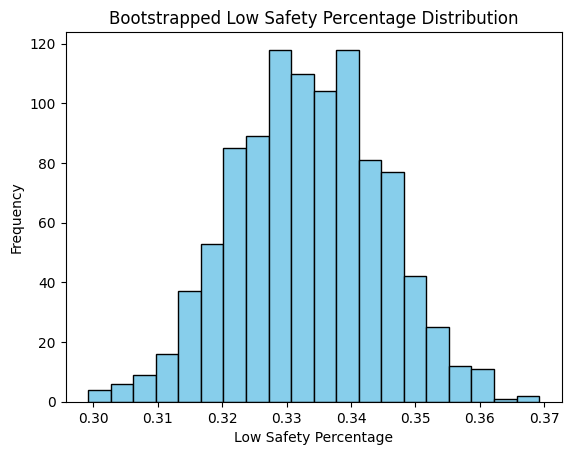

In [6]:
# -------------------------------------------------------
# ✅ Checkpoint 4: Plot histogram of low safety proportions
# -------------------------------------------------------
mean_lp = np.mean(low_perc)
print(f"Mean of 'low' safety proportions: {mean_lp:.4f}")

# A diagramm with the distribution pf the percentage values for "low", they t3end to the mean value of the original Datafgrame
plt.hist(low_perc, bins=20, color='skyblue', edgecolor='black')
plt.title('Bootstrapped Low Safety Percentage Distribution')
plt.xlabel('Low Safety Percentage')
plt.ylabel('Frequency')
plt.show()
# Observation: The histogram shows a bell-shaped distribution
# centered around the true mean proportion (~0.333).

In [7]:
# -------------------------------------------------------
# ✅ Checkpoint 5: Calculate 95% Confidence Interval
# -------------------------------------------------------
# Sort the percentages and extract the 2.5th and 97.5th percentiles
low_perc.sort()
lower_bound = low_perc[25].round(4)
upper_bound = low_perc[975].round(4)

print(f'Average low percentage: {np.mean(low_perc).round(4)}')
print(f'95% Confidence Interval for low percentage: ({lower_bound}, {upper_bound})')
# Interpretation: We are 95% confident that the true proportion
# of "low" safety ratings lies within this interval.

Average low percentage: 0.3333
95% Confidence Interval for low percentage: (0.3125, 0.3553)


Bootstrapping: Why Sampling *With Replacement* Matters

Bootstrapping introduces randomness into each decision tree by sampling **with replacement** from the training data.  
Although this can over-represent some observations, it’s a deliberate design choice that improves the overall robustness of the random forest.

Key Reasons for Using Bootstrapping  
- **Simulates Sampling Variability:** Mimics drawing multiple datasets from the same population, allowing better estimation of variability and reducing overfitting.  
- **Increases Tree Diversity:** Each tree sees a different view of the data, leading to uncorrelated models whose errors average out.  
- **Statistical Foundation:** Bootstrapping’s “resample-with-replacement” design ensures each sample behaves like an independent dataset.  

Why Not Sample Without Replacement?  
- Produces less diverse trees, reducing the benefit of ensemble averaging.  
- Samples are more similar to the original dataset (lower variance, higher bias).  
- Fewer unique dataset combinations, limiting randomness across trees.  

Trade-Off Summary  
| Method | Pros | Cons |
|--------|------|------|
| **With Replacement (Bootstrapping)** | High diversity, strong ensemble effect, well-established method | Some rows may appear multiple times |
| **Without Replacement (Subsampling)** | Simpler, no duplicates | Lower diversity, weaker ensemble performance |

Takeaway  
Bootstrapping intentionally adds variability by resampling with replacement, creating more diverse and independent trees that, when combined, make the random forest more stable and accurate.


**Interpretation of the Bootstrapping Result**

If the proportion of "low" safety values in the bootstrapped sample is close to the original dataset’s proportion, this indicates that:

Although bootstrapping resamples the data with replacement,

The overall distribution of categories (e.g., "low", "med", "high") remains roughly consistent with the original dataset.

In essence, bootstrapping introduces random variation while preserving the underlying statistical structure of the data.

Each bootstrapped sample is a slightly different version of the original dataset, yet the relative frequency of "low" safety ratings tends to remain similar to the original.

This consistency ensures that ensemble methods like Random Forests can combine results from many bootstrapped trees without losing the core patterns of the training data.

# Bagging

Bagging, short for Bootstrap Aggregating, is the process by which random forests create diverse decision trees and then combine their predictions to improve model performance.

The idea begins with bootstrapping — training each decision tree on a different subset of the data sampled with replacement. Once multiple trees have been trained, their results are aggregated to form the final prediction.

How Bagging Works:

1. Bootstrap Sampling: Each tree is trained on a random subset of the training data, created through bootstrapping.  
2. Independent Model Training: Every tree is grown independently from its own bootstrapped sample.  
3. Aggregation of Results:  
   - For classification, the final prediction is determined by majority vote across all trees.  
   - For regression, the final prediction is the average of all tree outputs.  

This ensemble approach significantly reduces variance and helps prevent overfitting — one of the main weaknesses of a single decision tree.

Example Dataset:

We’ll apply bagging to the same car evaluation dataset used previously, which contains the following features:

| Feature  | Description |
|-----------|-------------|
| `buying`  | Buying price (`vhigh`, `high`, `med`, `low`) |
| `maint`   | Maintenance cost (`vhigh`, `high`, `med`, `low`) |
| `doors`   | Number of doors (`2`, `3`, `4`, `5more`) |
| `persons` | Passenger capacity (`2`, `4`, `more`) |
| `lugboot` | Size of trunk (`small`, `med`, `big`) |
| `safety`  | Safety rating (`low`, `med`, `high`) |

The target variable is `accep`, which indicates whether a car is acceptable (True) or unacceptable (False).

By combining multiple trees through bagging, a random forest achieves higher stability, reduces overfitting, and generally improves predictive accuracy compared to individual decision trees.


In [12]:
from sklearn.metrics import accuracy_score

In [14]:
# -------------------------------------------------------
# ✅ Checkpoint 1
# Train a decision tree with max_depth=5 and evaluate accuracy on test data.
# -------------------------------------------------------
dt = DecisionTreeClassifier(max_depth=5, random_state=0)
dt.fit(x_train, y_train)
y_pred = dt.predict(x_test)
base_acc = accuracy_score(y_test, y_pred)
print(f"Checkpoint 1 — DT@full-train accuracy: {base_acc:.4f}")

Checkpoint 1 — DT@full-train accuracy: 0.8588


In [15]:
# -------------------------------------------------------
# ✅ Checkpoint 2
# Use a provided bootstrapped set of indices (random_state=0) to fit another tree.
# Evaluate accuracy on the test set for this new classifier.
# -------------------------------------------------------
# This gives us back the indices of the new sampled distribution
ids = x_train.sample(len(x_train), replace=True, random_state=0).index
dt_boot = DecisionTreeClassifier(max_depth=5, random_state=0)
# the list of indices get applied to the x_train and y_train to assure 
# that the right combination of x and y are used for the training
dt_boot.fit(x_train.loc[ids], y_train.loc[ids])
boot_pred = dt_boot.predict(x_test)
boot_acc = accuracy_score(y_test, boot_pred)
print(f"Checkpoint 2 — DT@bootstrap(rs=0) accuracy: {boot_acc:.4f}")

Checkpoint 2 — DT@bootstrap(rs=0) accuracy: 0.8912


In [16]:
# -------------------------------------------------------
# ✅ Checkpoint 3
# Build 10 different bootstrapped trees in a loop.
# Save each test-set prediction (y_pred) into 'preds'.
# Take the average (bagging) and store as 'ba_pred' (will be floats in [0,1]).
# -------------------------------------------------------
preds = []
for i in range(10):
    # New bootstrap sample with a different seed each iteration
    ids_i = x_train.sample(len(x_train), replace=True, random_state=i).index
    tree_i = DecisionTreeClassifier(max_depth=5, random_state=i)
    tree_i.fit(x_train.loc[ids_i], y_train.loc[ids_i])
    # This appends a list of True and False to pred
    preds.append(tree_i.predict(x_test))  # 0/1 array

preds = np.array(preds)             # shape: (10, n_test)
print(preds[0])

[ True  True False False False  True False False  True  True False False
  True False False  True  True False  True False  True  True  True False
 False False False False  True False  True  True False  True  True False
  True False False False False False False False  True False False  True
 False False False  True False False False False False False False  True
  True  True False  True  True  True False False False False False  True
  True False  True  True False  True  True False  True  True False False
  True False False  True False False False  True  True False False  True
 False  True  True  True False  True  True False  True  True  True  True
 False False False False  True  True False  True  True False False False
 False False  True False False False False  True  True False False False
  True False False False False False  True False False False False False
 False False  True False False  True  True  True False False False False
 False False False False  True False False False  T

In [17]:
preds.shape

(10, 432)

In [18]:
# turns boolean into numbers, how? True is a 1 and False is a 0, so the mean calculates the average column-wise
# being preds.shape == (10, 432), it returns an array oflen 432, 
# with the average of the predictions (True/False or 1/0) for the 10 trees
ba_pred = preds.mean(axis=0)        # averaged predictions (floats)

In [19]:
# -------------------------------------------------------
# ✅ Checkpoint 4
# Compute accuracy of the bagged predictions.
# Note: 'ba_pred' is averaged (floats), so threshold at 0.5 to get binary labels.
# -------------------------------------------------------
# this turns once more the numbers int boolean, 
# giving back an array of True if the value is >= 0.5 (half of the tree returned True > makority vote)
# otherwise giving False
ba_accuracy = accuracy_score(ba_pred>=0.5, y_test)
print(f"Checkpoint 4 — Bagged(10) accuracy: {ba_accuracy:.4f}")

# (Optional) Quick summary
print("\nSummary:")
print(f"  Single DT (full train):       {base_acc:.4f}")
print(f"  Single DT (bootstrap rs=0):   {boot_acc:.4f}")
print(f"  Bagged DTs (10 models):       {ba_accuracy:.4f}")

Checkpoint 4 — Bagged(10) accuracy: 0.9097

Summary:
  Single DT (full train):       0.8588
  Single DT (bootstrap rs=0):   0.8912
  Bagged DTs (10 models):       0.9097


**What the code is doing (step-by-step)**

preds construction

Each loop trains a DecisionTreeClassifier on a bootstrapped version of x_train, y_train.

dt.predict(x_test) returns a vector of booleans (True/False) because your y is boolean.

preds becomes a list of 10 such vectors → shape (10, len(x_test)), e.g. (10, 432).

Averaging predictions

np.array(preds) converts to a 2D boolean array; in NumPy, True→1, False→0.

mean(0) computes the per-sample average across trees, i.e. the fraction of trees voting True for each test point.

ba_pred ∈ [0,1] for each sample (e.g., 0.7 means 7/10 trees predicted True).

Majority vote via thresholding

(ba_pred >= 0.5) converts those fractions back to booleans (majority voting).

So you’re not comparing booleans to numbers in accuracy_score; you’ve converted the numbers to booleans first.

Accuracy computation

accuracy_score(y_true, y_pred) compares two boolean arrays element-wise and reports the fraction equal.

In your call you wrote accuracy_score(ba_pred>=0.5, y_test). It still works (symmetry), but the conventional order is accuracy_score(y_test, ba_pred>=0.5).

# Random Feature Selection

In addition to bootstrapping samples from the dataset, we can introduce further variability by randomly selecting which features are used to train each tree.

For the car dataset, the original features are:

- Price of the car: “vhigh”, “high”, “med”, or “low”  
- Maintenance cost: “vhigh”, “high”, “med”, or “low”  
- Number of doors: “2”, “3”, “4”, or “5more”  
- Capacity (number of people): “2”, “4”, or “more”  
- Trunk size: “small”, “med”, or “big”  
- Safety rating: “low”, “med”, or “high”

The target variable, `accep`, represents whether a car is acceptable (`True` or `False`).  
After dummy encoding the categorical features, the dataset contains 15 total features for training (`x_train`) and testing (`x_test`).

When using a single decision tree, all available features are considered at each split, and the best one is chosen based on the highest information gain.  
However, in ensemble methods like Random Forests, **randomly selecting a subset of fea**


In [20]:
# ------------------------------------------------------------
# Random Feature Selection with Aggregated Predictions (Ensemble)
# ------------------------------------------------------------
# Goal:
# Embed the step-by-step instructions directly into executable code,
# with clear, numbered comments aligned to the checkpoints.

# Train/test split
x_train, x_test, y_train, y_test = train_test_split(
    X, y, random_state=0, test_size=0.25
)

# ----------------------------
# Baseline Decision Tree (All Features)
# ----------------------------
# Train a baseline tree using the full feature set and evaluate on the test set
dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)
accuracy_dt = dt.score(x_test, y_test)
print("Accuracy of DT on test set (full feature set):")
print(accuracy_dt)

Accuracy of DT on test set (full feature set):
0.9467592592592593


In [21]:
# ============================================================
# Checkpoint 1
# ============================================================
# Step 1.1: Create a random sample of 10 features from the 15 total features
rand_features = np.random.choice(x_train.columns, 10)

# Step 1.2: Define a new decision tree classifier (no pre-selected hyperparameters)
dt2 = DecisionTreeClassifier()

# Step 1.3: Train dt2 ONLY on the selected random feature subset
dt2.fit(x_train[rand_features], y_train)

# Step 1.4: Evaluate on the test set using ONLY those same features
accuracy_dt2 = dt2.score(x_test[rand_features], y_test)
print("Accuracy of DT on test set (random feature sample):")
print(accuracy_dt2)

Accuracy of DT on test set (random feature sample):
0.7291666666666666


In [22]:
# ============================================================
# Checkpoint 2
# ============================================================
# Step 2.1: Initialize a container for predictions from 10 different random-feature trees
predictions = []

# Step 2.2: Loop ten times; each iteration:
#   - Selects 10 random features
#   - Fits dt2 on the corresponding training subset
#   - Appends predictions on the corresponding test subset
for _ in range(10):
    rand_features = np.random.choice(x_train.columns, 10)
    dt2.fit(x_train[rand_features], y_train)
    preds = dt2.predict(x_test[rand_features])
    predictions.append(preds)

# Convert list of arrays into a 2D NumPy array of shape (10, n_samples)
predictions = np.array(predictions)

In [23]:
# ============================================================
# Checkpoint 3
# ============================================================
# Step 3.1: Compute the mean prediction per sample across the 10 classifiers.
#           Since it's binary (False/True → 0/1), this acts like a probability.
prob_predictions = predictions.mean(axis=0)

# Step 3.2: Aggregate to a final class prediction using majority vote (> 0.5 → True)
agg_predictions = prob_predictions > 0.5

# Step 3.3: Compute accuracy of the aggregated predictions
# NOTE: accuracy_score expects (y_true, y_pred)
agg_accuracy = accuracy_score(y_test, agg_predictions)

print("Accuracy of aggregated predictions from 10 random-feature trees:")
print(agg_accuracy)

Accuracy of aggregated predictions from 10 random-feature trees:
0.7175925925925926


**Why the accuracy drops when using random feature subsets**

Your experiment tests three setups:
1) Single tree with all features
2) Single tree with a random subset of features
3) An ensemble of 10 trees, each trained on a random subset of features

Why accuracy often decreases in this demo

- You weakened each tree without enough pay-off  
  Limiting features reduces each tree’s strength. Ensembles win when many *reasonably strong* but *less correlated* trees are combined. With only 10 trees, the strength loss can outweigh the benefit.

- Randomness is at the tree level, not the split level  
  True Random Forests sample a subset of features at *every split*, creating much stronger decorrelation than picking 10 columns once per tree.

- No bootstrapping of rows  
  Random Forests also sample rows with replacement (bagging). Only randomizing features gives less diversity and weaker variance reduction.

- Hard votes instead of probability averaging  
  Averaging `predict` (hard 0/1) and thresholding at 0.5 discards uncertainty. Averaging `predict_proba` and then thresholding is usually better.

- Single train/test split variance  
  A plain tree can “luck out” on a particular split. Small datasets and a single split can mask the true generalization effect—use cross-validation.

- Threshold and class imbalance  
  If classes are imbalanced, a 0.5 threshold may be suboptimal. Metrics like AUC, F1, or balanced accuracy can give a fairer picture.

What’s missing compared to a proper Random Forest

- Feature subsampling at every split (`max_features`)
- Row bootstrapping (`bootstrap=True`)
- Many trees (typically 100–1000+)
- Probability averaging (or majority vote across many trees)
- Regularized trees (e.g., `max_depth`, `min_samples_leaf`) to reduce overfitting

How to make the ensemble actually help

1) Use a proper Random Forest

2) If keeping your custom loop, average probabilities and add bootstrapping

3) Evaluate robustly

- Use stratified k-fold cross-validation to reduce split-specific noise.

- Consider balanced accuracy, F1, or AUC, and tune the decision threshold if needed.

# Bagging in scikit-learn

Bagging (“bootstrap aggregating”) combines two ideas we explored: training base learners on bootstrapped samples and (optionally) using random subsets of features. Doing both increases diversity among the learners and typically improves generalization by reducing variance while keeping bias roughly similar.

In scikit-learn, this is implemented with `BaggingClassifier`. You provide:
- the base model to bag (e.g., a `DecisionTreeClassifier(max_depth=5)`),
- how many models to train (`n_estimators`),
- how many samples/features each model sees (`max_samples`, `max_features`),
- whether to sample rows/features with replacement (`bootstrap`, `bootstrap_features`).

After instantiation, you use `.fit()`, `.predict()`, and `.score()` as usual.

Example (decision tree as base estimator, depth 5):
```python
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

base_tree = DecisionTreeClassifier(max_depth=5, random_state=0)

bag = BaggingClassifier(
    base_estimator=base_tree,   # in newer versions: estimator=base_tree
    n_estimators=100,           # number of bootstrapped trees
    max_samples=1.0,            # fraction or count of rows per tree
    max_features=1.0,           # fraction or count of features per tree
    bootstrap=True,             # sample rows with replacement
    bootstrap_features=False,   # (optional) sample features with replacement
    n_jobs=-1,                  # use all cores
    random_state=0
)

bag.fit(x_train, y_train)
test_accuracy = bag.score(x_test, y_test)
print(test_accuracy)


In [24]:
# ------------------------------------------------------------
# Bagging in scikit-learn — Checkpoints with Embedded Instructions
# ------------------------------------------------------------
# Goal: Implement bagging with different base estimators and feature sampling,
# and report test accuracy for each configuration.

# Train/test split (fixed random_state for reproducibility)
x_train, x_test, y_train, y_test = train_test_split(
    X, y, random_state=0, test_size=0.25, stratify=y
)

In [28]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, RandomForestRegressor

In [30]:
# ------------------------------------------------------------
# Checkpoint 1
# ------------------------------------------------------------
# Step 1.1: Instantiate BaggingClassifier with DecisionTreeClassifier(max_depth=5)
#           Use 10 estimators; bootstrap rows (default True); use all features per estimator.
bag_dt = BaggingClassifier(
    DecisionTreeClassifier(max_depth=5, random_state=0),
    n_estimators=10,
    n_jobs=-1,
    random_state=0
)

# Step 1.2: Fit on training data
bag_dt.fit(x_train, y_train)

# Step 1.3: Evaluate on test data; store & print bag_accuracy
bag_accuracy = bag_dt.score(x_test, y_test)
print('Accuracy score of Bagged DT (10 estimators, all features):')
print(bag_accuracy)

Accuracy score of Bagged DT (10 estimators, all features):
0.9189814814814815


In [32]:
# ------------------------------------------------------------
# Checkpoint 2
# ------------------------------------------------------------
# Step 2.1: Instantiate BaggingClassifier with max_features=10
#           (each base estimator gets a random subset of 10 features)
bag_dt_10 = BaggingClassifier(
    DecisionTreeClassifier(max_depth=5, random_state=0),
    n_estimators=10,
    max_features=10,        # draw 10 features (count) per estimator
    n_jobs=-1,
    random_state=0
)

# Step 2.2: Fit and evaluate; store & print bag_accuracy_10
bag_dt_10.fit(x_train, y_train)
bag_accuracy_10 = bag_dt_10.score(x_test, y_test)
print('Accuracy score of Bagged DT (10 estimators, max_features=10):')
print(bag_accuracy_10)

Accuracy score of Bagged DT (10 estimators, max_features=10):
0.8773148148148148


In [34]:
from sklearn.linear_model import LogisticRegression

In [35]:
# ------------------------------------------------------------
# Checkpoint 3
# ------------------------------------------------------------
# Step 3.1: Change base estimator to LogisticRegression()
#           Use solver suited for small/medium data; increase max_iter for convergence.
bag_lr = BaggingClassifier(
    LogisticRegression(
        solver='liblinear',   # robust on small dense data
        max_iter=1000,
        random_state=0
    ),
    n_estimators=10,
    max_features=10,
    n_jobs=-1,
    random_state=0
)

# Step 3.2: Fit and evaluate; store & print bag_accuracy_lr
bag_lr.fit(x_train, y_train)
bag_accuracy_lr = bag_lr.score(x_test, y_test)
print('Accuracy score of Bagged Logistic Regression (10 estimators, max_features=10):')
print(bag_accuracy_lr)

Accuracy score of Bagged Logistic Regression (10 estimators, max_features=10):
0.8611111111111112


# Random Forests: Train and Predict using scikit-learn

Random forests combine decision trees using two kinds of randomness:
- **Row sampling (bagging):** each tree is trained on a bootstrapped sample of the training data.
- **Feature sampling at every split:** instead of choosing one random set of features once per tree, **each split** considers a fresh random subset of features.

How split-level feature sampling works
- First split: pick a random subset of features (e.g., price, doors, safety), choose the best splitter among them.
- Next split(s): pick a **new** random subset (e.g., maint, doors, trunk), choose the best splitter, and continue until the tree is complete.
- This per-split randomness reduces correlation among trees while keeping trees relatively strong.

Choosing how many features per split
- A common rule of thumb for classification: use about **\(\sqrt{d}\)** features at each split, where \(d\) is the total number of features.
- Example: if \(d = 25\), consider **5** features per split.
- Small feature sets may limit how closely you can follow this rule, but the principle still applies.

Using `RandomForestClassifier` in scikit-learn
- `RandomForestClassifier` (from `sklearn.ensemble`) implements both bagging and split-level feature sampling for you.
- The API mirrors `DecisionTreeClassifier`: use `.fit()`, `.predict()`, and `.score()` in the same way.

Example:
```python
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,     # number of trees
    max_features='sqrt', # ~ sqrt(d) features per split
    bootstrap=True,      # bootstrapped row samples
    n_jobs=-1,           # parallelism
    random_state=0
)

rf.fit(x_train, y_train)
test_acc = rf.score(x_test, y_test)
print(test_acc)


In [40]:
# ------------------------------------------------------------
# Random Forest — Training, Prediction, and Evaluation Metrics
# ------------------------------------------------------------
# Checkpoint 1:
#   Create a RandomForestClassifier with default parameters,
#   retrieve parameters via .get_params(), store as rf_params, and print.
#
# Checkpoint 2:
#   Fit on training data; predict on x_test into y_pred;
#   compute accuracy as rf_accuracy and print.
#
# Checkpoint 3:
#   Compute precision, recall, and confusion matrix on test set;
#   store as rf_precision, rf_recall, rf_confusion_matrix; print.
# ------------------------------------------------------------

# Imports
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score
)

In [41]:
# Train/test split
x_train, x_test, y_train, y_test = train_test_split(
    X, y, random_state=0, test_size=0.25
)

In [42]:
# ------------------------------------------------------------
# Checkpoint 1 — Instantiate RF and print parameters
# ------------------------------------------------------------
rf = RandomForestClassifier()     # default parameters
rf_params = rf.get_params()       # retrieve parameters dictionary
print('Random Forest parameters:')
print(rf_params)

Random Forest parameters:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [43]:
# ------------------------------------------------------------
# Checkpoint 2 — Fit, predict, and compute accuracy
# ------------------------------------------------------------
rf.fit(x_train, y_train)          # train on bootstrapped trees by default
y_pred = rf.predict(x_test)       # predicted classes on test set
# Either rf.score(...) or accuracy_score(...), both are fine:
rf_accuracy = rf.score(x_test, y_test)
print('Test set accuracy:')
print(rf_accuracy)

Test set accuracy:
0.9398148148148148


In [44]:
# ------------------------------------------------------------
# Checkpoint 3 — Precision, Recall, Confusion Matrix
# ------------------------------------------------------------
rf_precision = precision_score(y_test, y_pred)
print(f'Test set precision: {rf_precision}')
rf_recall = recall_score(y_test, y_pred)
print(f'Test set recall: {rf_recall}')
rf_confusion_matrix = confusion_matrix(y_test, y_pred)
print('Test set confusion matrix:')
print(rf_confusion_matrix)

Test set precision: 0.9435483870967742
Test set recall: 0.8602941176470589
Test set confusion matrix:
[[289   7]
 [ 19 117]]


# Random Forest Regressor

Random forests can be used for **regression** when the target variable is continuous (e.g., a numeric `price`) rather than categorical (e.g., acceptable vs not acceptable). In this setup, each tree predicts a numeric value, and the forest’s prediction is the **average** of the individual trees’ outputs.

Key differences vs. classification
- **Target type:** continuous values (regression) instead of class labels (classification).
- **Aggregation:** average of tree predictions (regression) vs. majority vote or probability averaging (classification).
- **Loss/criteria:** trees typically optimize variance reduction (e.g., MSE-based splits) rather than impurity (e.g., Gini/entropy).

Using `RandomForestRegressor` (scikit-learn)
- Import from `sklearn.ensemble` and use the same workflow as classifiers: `.fit()`, `.predict()`, `.score()`.
- The default `.score()` for regressors is the **\(R^2\)** (coefficient of determination).

Default evaluation: \(R^2\)
- Measures proportion of variance explained by the model:
  
  $$
  R^2 \;=\; 1 - \frac{\sum_{i=1}^{n}\left(y_i - \hat{y}_i\right)^2}{\sum_{i=1}^{n}\left(y_i - \bar{y}\right)^2}
  $$
  
  where \(y_i\) are true values, \(\hat{y}_i\) are predictions, and \(\bar{y}\) is the mean of \(y\).
- Values close to 1 indicate better fit; values \(\le 0\) indicate the model performs no better (or worse) than predicting the mean.

Other useful regression metrics
- **MSE:** \( \text{MSE} = \frac{1}{n}\sum_{i=1}^{n} (y_i - \hat{y}_i)^2 \)
- **RMSE:** \( \text{RMSE} = \sqrt{\text{MSE}} \)
- **MAE:** \( \text{MAE} = \frac{1}{n}\sum_{i=1}^{n} |y_i - \hat{y}_i| \)

Practical notes
- The example uses a synthetic continuous `price` to illustrate regression on the same car features.
- Typical knobs: `n_estimators`, `max_depth`, `min_samples_leaf`, and `max_features` (often set to `sqrt(d)` or a fraction).
- Random forests are robust to nonlinearity and feature interactions; they require minimal preprocessing and handle mixed feature types well (use one-hot encoding for categoricals).


In [45]:
# ------------------------------------------------------------
# Random Forest Regressor — Training, Scoring (R^2), and MAE
# ------------------------------------------------------------
# Checkpoint 1:
#   1) Initialize RandomForestRegressor() as rfr
#   2) Fit on (x_train, y_train)
#   3) Compute default scores (R^2) on train and test:
#      - r_squared_train, r_squared_test
#   4) Print both R^2 values
#
# Checkpoint 2:
#   1) Compute average price of all cars: avg_price
#   2) Compute MAE on train and test:
#      - mae_train, mae_test
#   3) Print avg_price, mae_train, mae_test
# ------------------------------------------------------------

# Imports
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# ----------------------------
# Data Loading & Feature Prep
# ----------------------------
# Load UCI Car Evaluation dataset (categorical features + acceptability label)
df = pd.read_csv(
    'https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data',
    names=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'accep']
)

# (Not used in regression target, but kept for parity with earlier steps)
df['accep'] = ~(df['accep'] == 'unacc')

# One-hot encode the 6 categorical input features
X = pd.get_dummies(df.iloc[:, 0:6], drop_first=True)

# ------------------------------------------------------------
# Create a synthetic continuous regression target `price`
# ------------------------------------------------------------
# For illustration only: synthetic prices with trend + noise
rng = np.random.default_rng(0)
fake_prices = 15000 + 25 * df.index.values + rng.normal(0, 5000, size=df.shape[0])
df['price'] = fake_prices
y = df['price']

# Train/test split
x_train, x_test, y_train, y_test = train_test_split(
    X, y, random_state=0, test_size=0.25
)

# ------------------------------------------------------------
# Checkpoint 1 — Train and Score (R^2)
# ------------------------------------------------------------
# Step 1.1: Initialize the Random Forest Regressor
rfr = RandomForestRegressor(random_state=0)

# Step 1.2: Fit the model on training data
rfr.fit(x_train, y_train)

# Step 1.3: Compute R^2 on train and test sets
r_squared_train = rfr.score(x_train, y_train)
r_squared_test = rfr.score(x_test, y_test)

# Step 1.4: Print R^2 scores
print(f"Train set R^2: {r_squared_train:.4f}")
print(f"Test set R^2:  {r_squared_test:.4f}")

# ------------------------------------------------------------
# Checkpoint 2 — Average Price & Mean Absolute Error (MAE)
# ------------------------------------------------------------
# Step 2.1: Compute the average price over the whole dataset
avg_price = y.mean()

# Step 2.2: Predictions for MAE on train and test
y_pred_train = rfr.predict(x_train)
y_pred_test  = rfr.predict(x_test)

# Step 2.3: Compute MAE on train and test sets
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test  = mean_absolute_error(y_test, y_pred_test)

# Step 2.4: Print the mean price and both MAEs
print(f"Average price (overall): {avg_price:,.2f}")
print(f"Train set MAE:           {mae_train:,.2f}")
print(f"Test set MAE:            {mae_test:,.2f}")


Train set R^2: 0.9765
Test set R^2:  0.8064
Average price (overall): 36,495.70
Train set MAE:           1,633.02
Test set MAE:            4,678.91


# Final Remarks

- **Why it works:** Averaging many de-correlated trees lowers variance and improves stability over a single decision tree.  
- **Evaluate with multiple metrics:** Combine \(R^2\) with **MAE/RMSE** to gauge both explained variance and error magnitude.  
- **Guardrails against overfitting:** Limit tree depth (`max_depth`) or enforce minimum leaf sizes (`min_samples_leaf`), and validate with cross-validation.  
- **Feature considerations:** Try `max_features='sqrt'` or a fraction to increase tree diversity; review feature importances for sanity checks, not as causal proof.  
- **Practical tuning:** Start with more trees (`n_estimators` 200–500), then adjust `max_depth` and `min_samples_leaf`; use `random_state` for reproducibility and `n_jobs=-1` for speed.  
- **Next steps:** Add pipeline steps (scaling if needed for other models), perform grid/random search for hyperparameters, and compare against baselines and simpler regressors.

Bottom line: `RandomForestRegressor` is a strong, low-maintenance baseline for nonlinear tabular regression—robust, interpretable enough to debug, and a solid benchmark for more advanced methods.
